In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import distutils as _distutils


In [5]:
IMAGE_SIZE=256
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50


In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=32
)

Found 4217 files belonging to 4 classes.


In [7]:
class_names=dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 0 1 2 2 3 3 2 1 0 3 0 3 2 0 0 3 2 3 3 3 2 0 0 1 2 3 1 2 1 3 3]


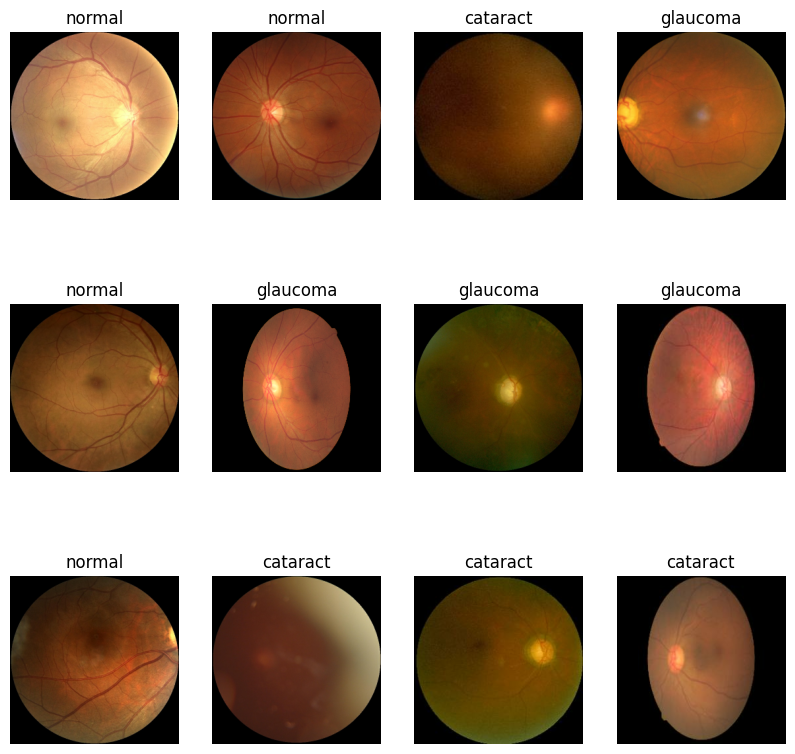

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
len(dataset)

132

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
#Building the Model

resize_and_rescale = tf.keras.Sequential([
layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
layers.Rescaling(1./255),
])

In [31]:
#Data Augmentation

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [32]:
#Applying Data Augmentation to Train Dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
#Compiling the Model

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.3135 - loss: 1.3564 - val_accuracy: 0.5457 - val_loss: 1.1161
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 99s 926ms/step - accuracy: 0.5243 - loss: 1.0569 - val_accuracy: 0.5433 - val_loss: 1.0384
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 91s 865ms/step - accuracy: 0.5617 - loss: 0.9275 - val_accuracy: 0.6442 - val_loss: 0.8889
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 92s 878ms/step - accuracy: 0.6388 - loss: 0.8223 - val_accuracy: 0.6875 - val_loss: 0.7810
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 92s 875ms/step - accuracy: 0.6848 - loss: 0.7101 - val_accuracy: 0.7019 - val_loss: 0.7281
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7043 - loss: 0.6643 - val_accuracy: 0.7404 - val_loss: 0.6520
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 105s 994ms/step - accuracy: 0.7363 - loss: 0.6324 - val_accuracy: 0.6971 - val_loss: 0.7180
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7300 - loss: 0.6190

In [38]:
scores = model.evaluate(test_ds)
scores

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.8857 - loss: 0.2767


[0.2920112907886505, 0.8839285969734192]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

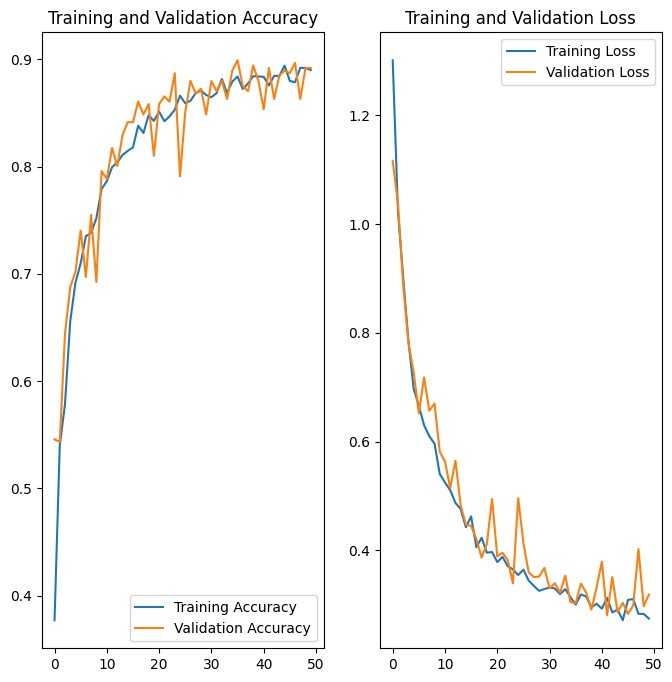

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [73]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Predict on the test set
predictions = model.predict(test_ds)

# Get actual labels from the test set
actual_labels = []
for images, labels in test_ds:
    actual_labels.extend(labels.numpy())

# Convert predictions to class labels
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Now you have actual_labels and predicted_labels, you can use them as needed
print("Actual Labels:", actual_labels)
print("Predicted Labels:", predicted_labels)

14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - accuracy: 0.8835 - loss: 0.3000
Test Accuracy: 0.8839285969734192
Test Loss: 0.2920112907886505
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step
Actual Labels: [2, 2, 2, 2, 2, 3, 0, 3, 1, 2, 3, 3, 3, 1, 2, 3, 1, 1, 0, 3, 1, 2, 2, 1, 2, 1, 0, 3, 2, 3, 0, 3, 3, 0, 3, 3, 1, 1, 3, 2, 3, 1, 0, 2, 0, 0, 2, 3, 0, 1, 1, 2, 0, 0, 0, 1, 2, 1, 2, 2, 2, 3, 0, 0, 3, 0, 2, 0, 1, 0, 3, 3, 0, 2, 0, 1, 1, 1, 1, 2, 1, 0, 1, 2, 3, 0, 1, 1, 1, 3, 0, 2, 0, 1, 3, 1, 1, 2, 0, 1, 3, 3, 0, 1, 2, 3, 2, 0, 2, 3, 2, 2, 3, 0, 1, 1, 1, 0, 0, 3, 3, 3, 3, 1, 3, 3, 3, 2, 1, 2, 2, 1, 3, 2, 3, 0, 0, 3, 0, 2, 0, 0, 2, 0, 3, 0, 3, 2, 2, 1, 2, 0, 0, 2, 1, 1, 1, 2, 3, 0, 2, 0, 0, 2, 3, 1, 3, 0, 3, 1, 1, 0, 3, 2, 0, 1, 3, 2, 1, 1, 0, 3, 0, 1, 0, 0, 2, 0, 3, 2, 0, 3, 3, 0, 1, 2, 3, 3, 2, 0, 2, 1, 1, 2, 3, 3, 1, 2, 3, 3, 0, 1, 1, 2, 3, 3, 2, 1, 2, 1, 0, 0, 1, 2, 3, 2, 1, 1, 0, 3, 3, 2, 1, 0, 3, 0, 0, 2, 0, 2, 0, 1, 3, 2, 1, 0, 1, 2, 2, 0, 3, 3, 1, 0, 1, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 2, 3, 3, 

In [ ]:
!pip install mlxtend

In [42]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step


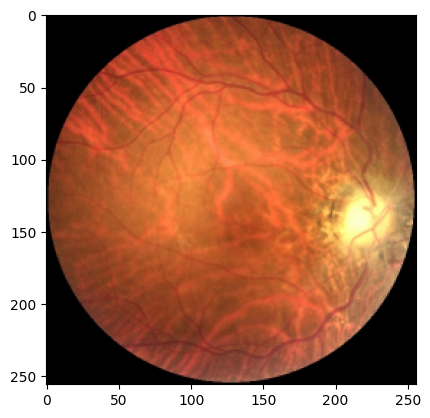

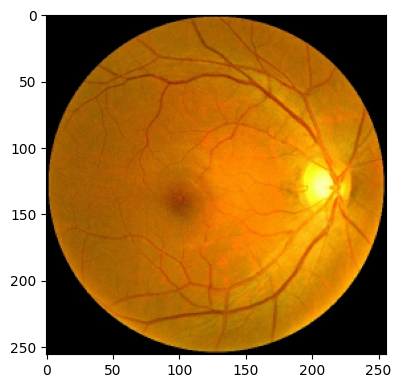

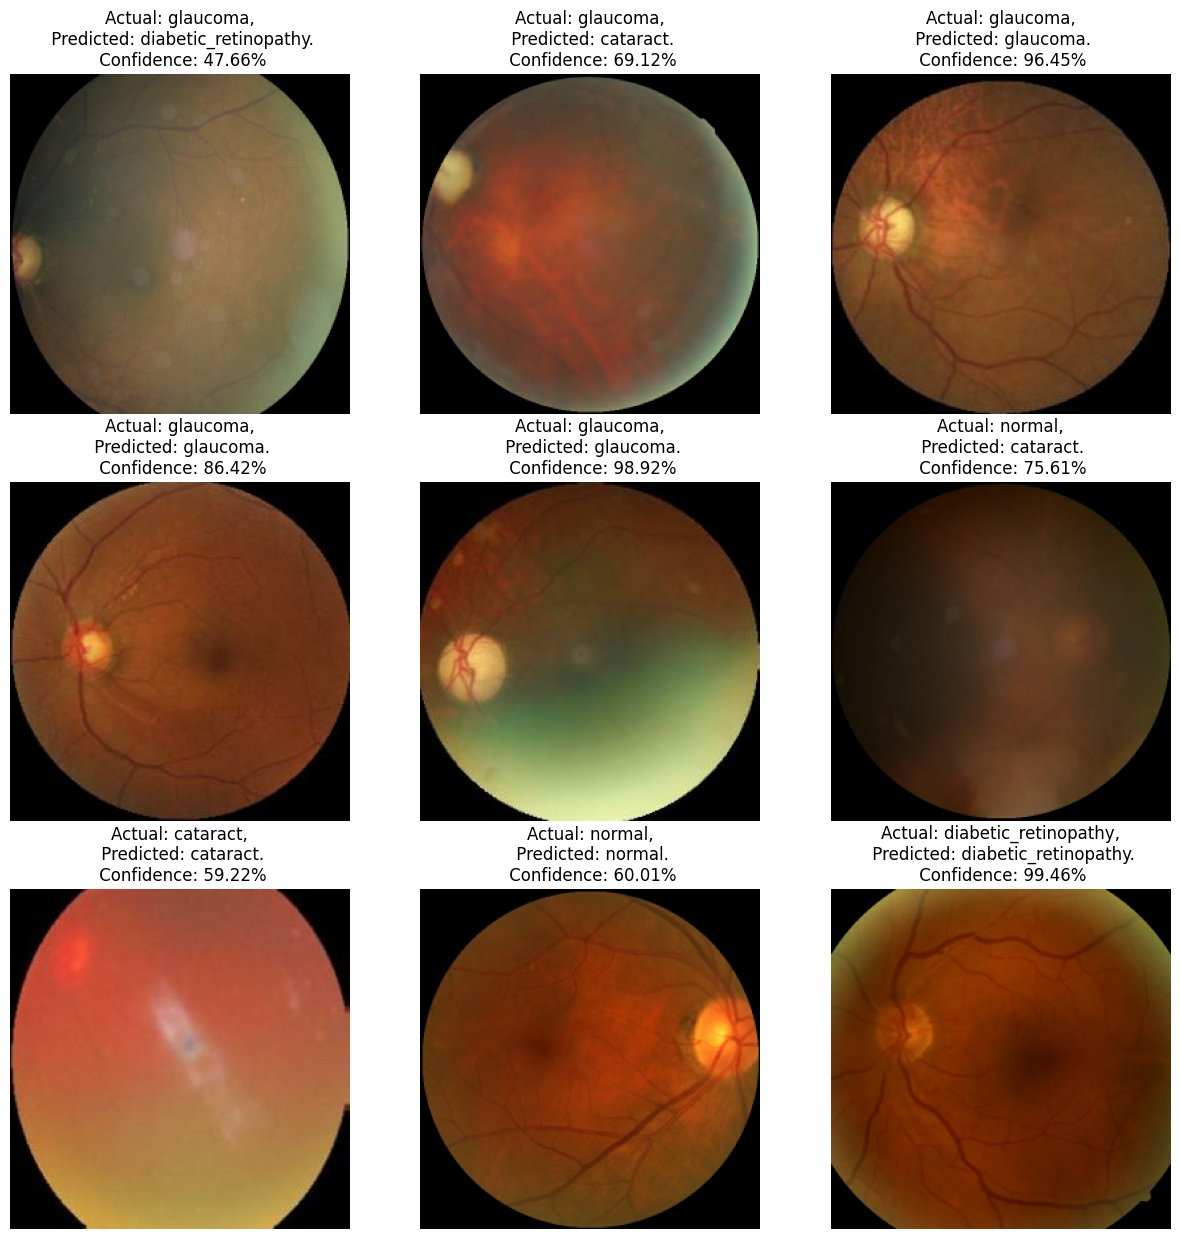

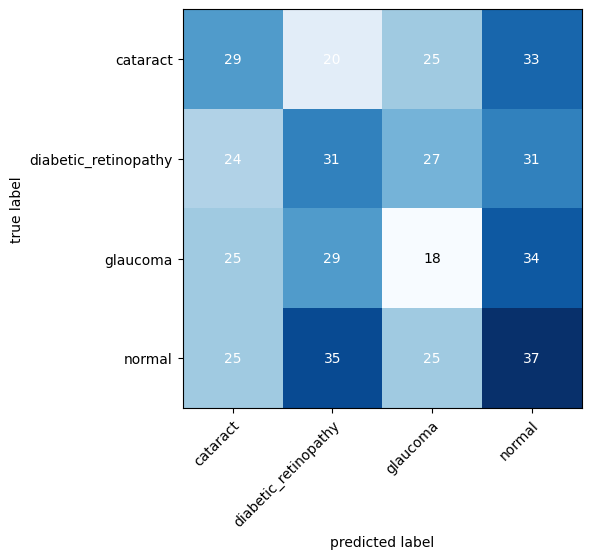

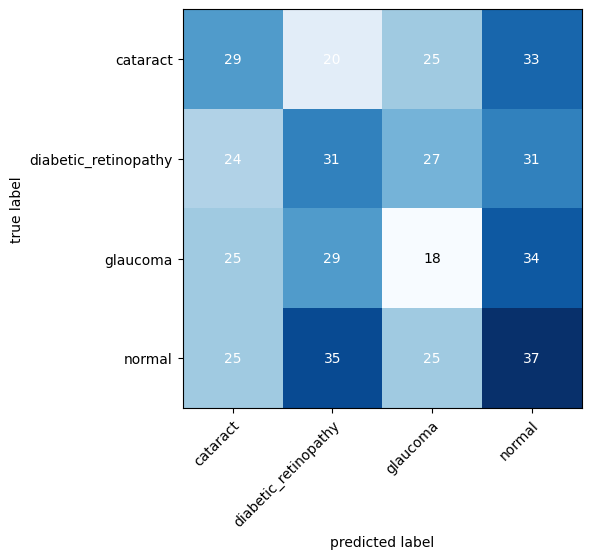

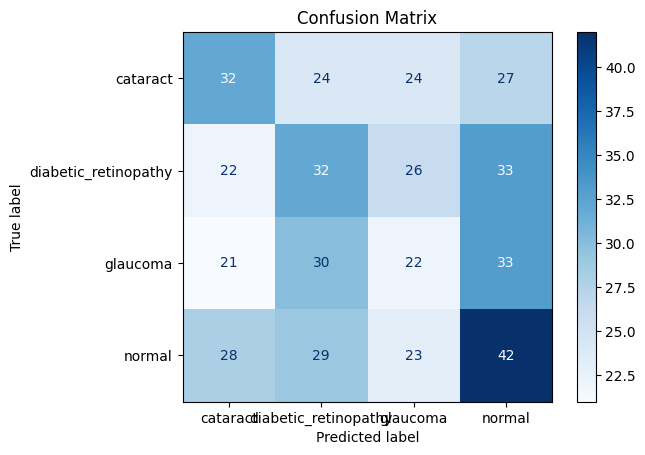

In [76]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get actual labels from the test set
actual_labels = []
for images, labels in test_ds:
    actual_labels.extend(labels.numpy())

# Convert predictions to class labels
predicted_labels = np.argmax(model.predict(test_ds), axis=1)

# Create confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
pip install seaborn

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


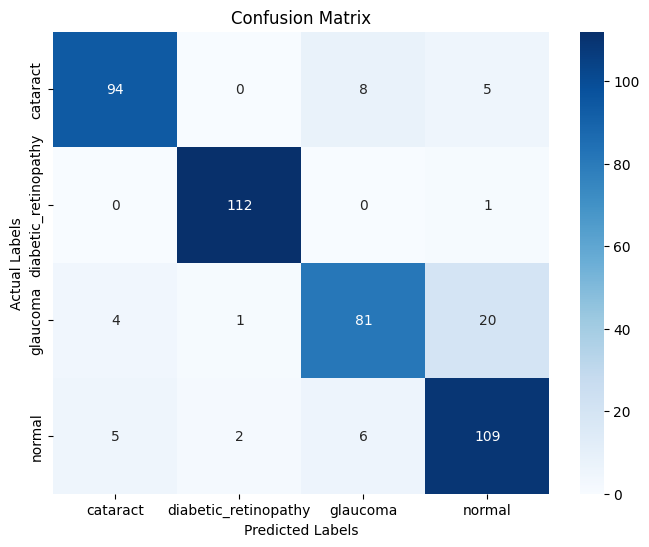

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to get actual and predicted labels
def get_actual_predicted_labels(model, test_ds):
    actual_labels = []
    predicted_labels = []

    for images, labels in test_ds:
        actual_labels.extend(labels.numpy())
        predictions = np.argmax(model.predict(images), axis=1)
        predicted_labels.extend(predictions)

    return np.array(actual_labels), np.array(predicted_labels)

# Get actual and predicted labels
actual_labels, predicted_labels = get_actual_predicted_labels(model, test_ds)

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()